In [1]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.layers import Conv1D, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
names = ['user-id', 'activity', 'timestamp', 'X', 'Y', 'Z', "NaN"]

data = pd.read_csv("./WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["Z"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["Z"] = df["Z"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


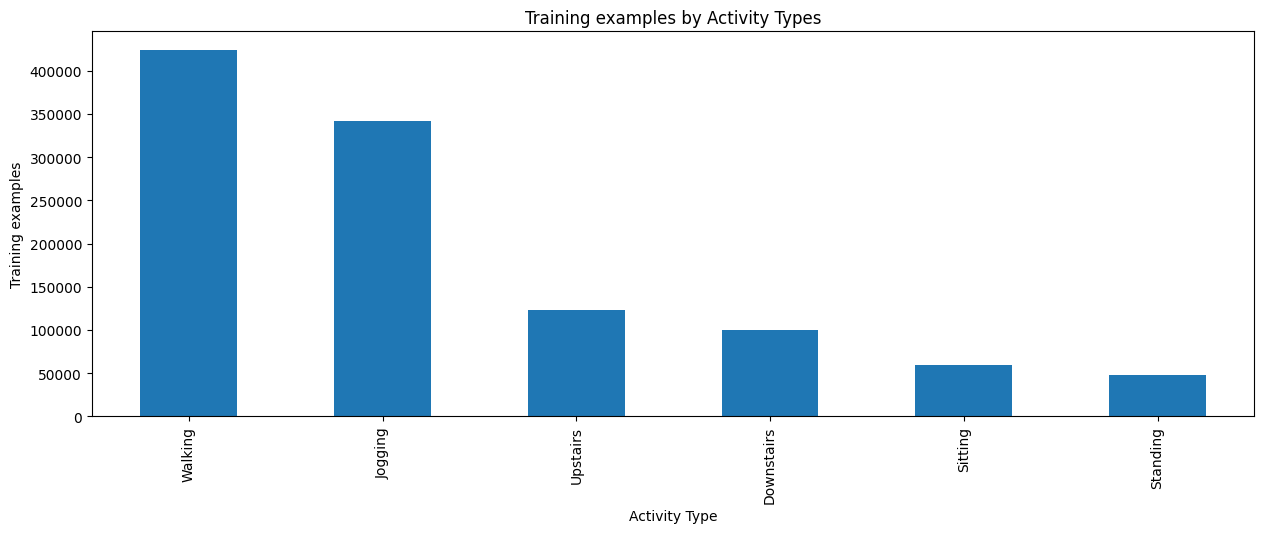

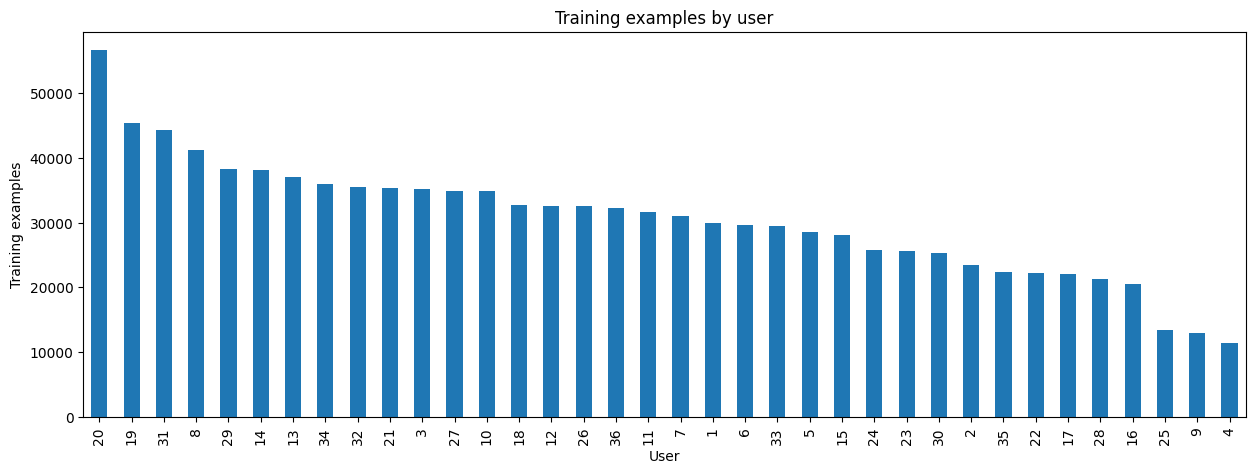

In [3]:
plt.figure(figsize=(15, 5))

plt.xlabel('Activity Type')
plt.ylabel('Training examples')
df['activity'].value_counts().plot(kind='bar',
                                  title='Training examples by Activity Types')
plt.show()

plt.figure(figsize=(15, 5))
plt.xlabel('User')
plt.ylabel('Training examples')
df['user-id'].value_counts().plot(kind='bar', 
                                 title='Training examples by user')
plt.show()

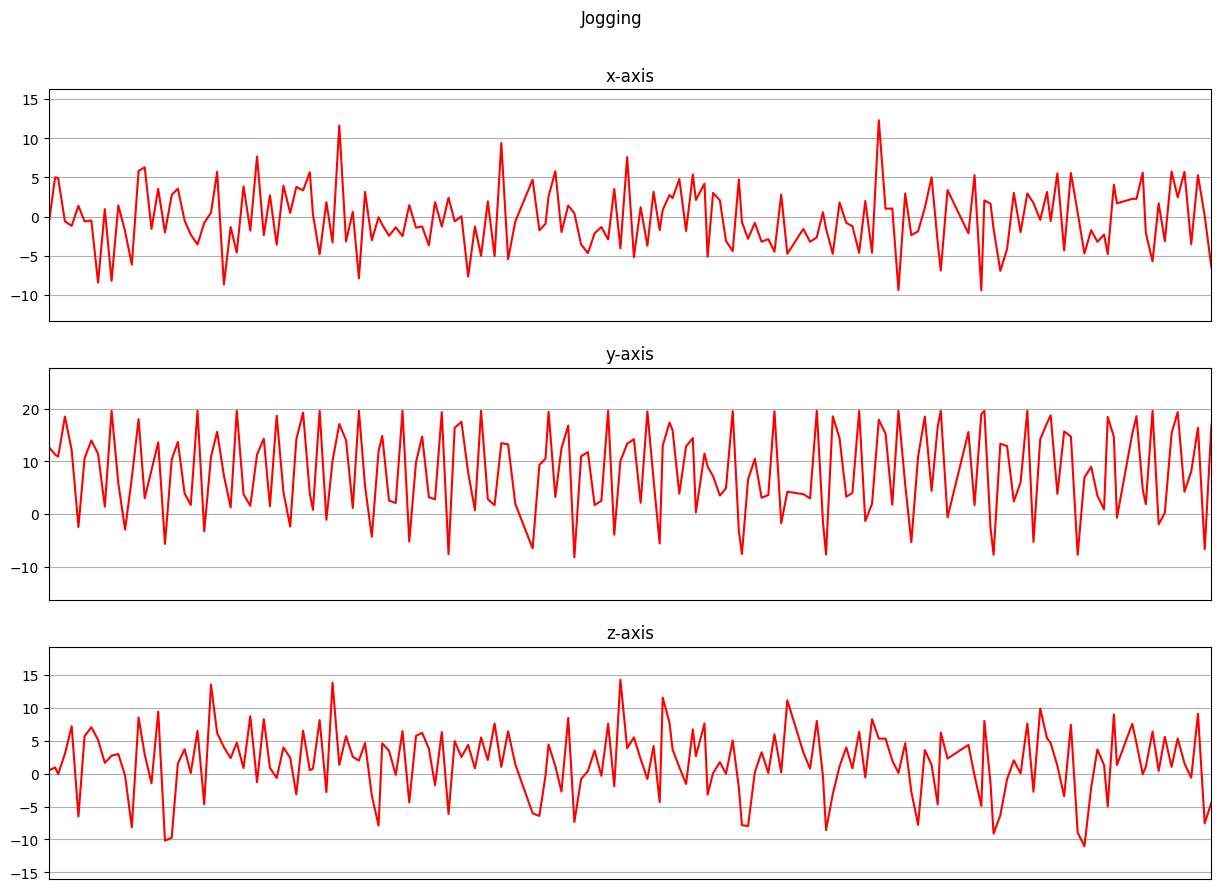

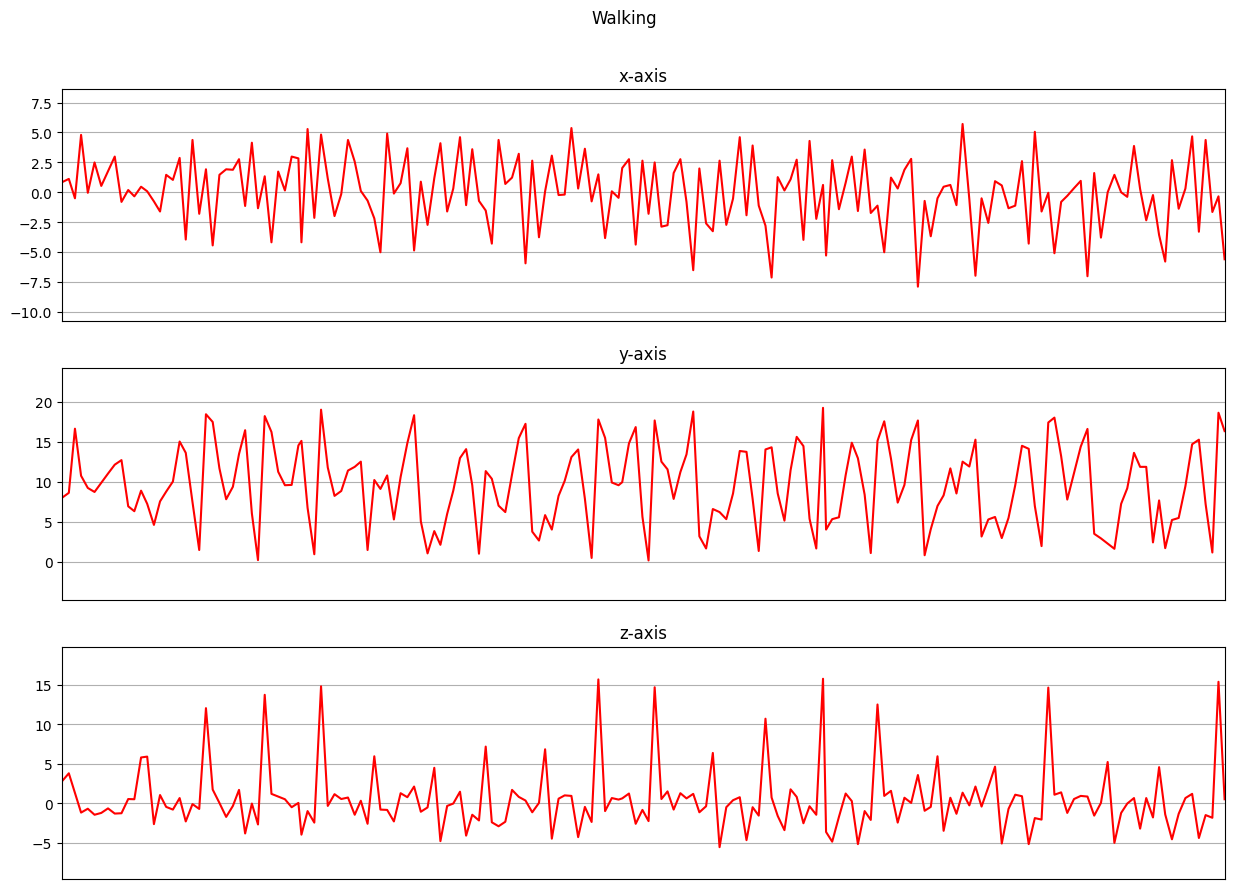

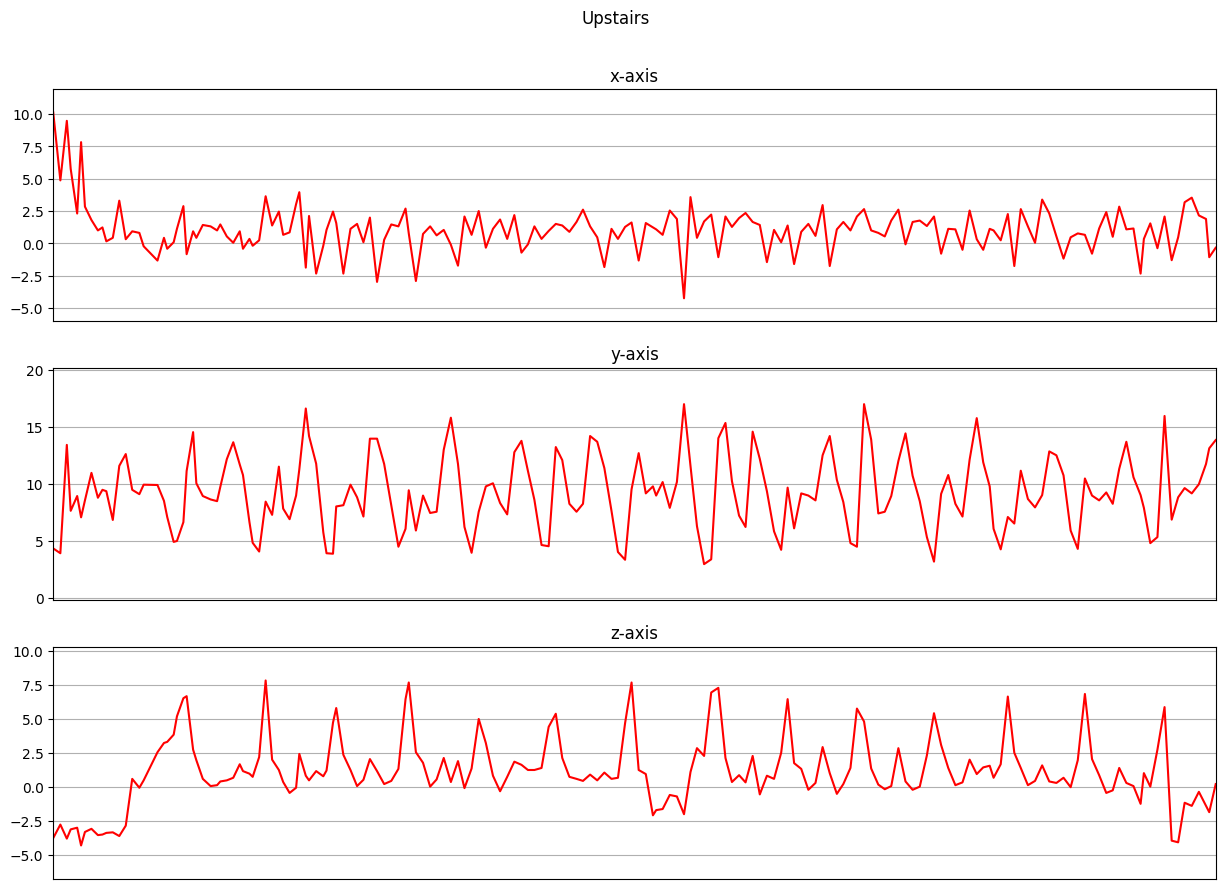

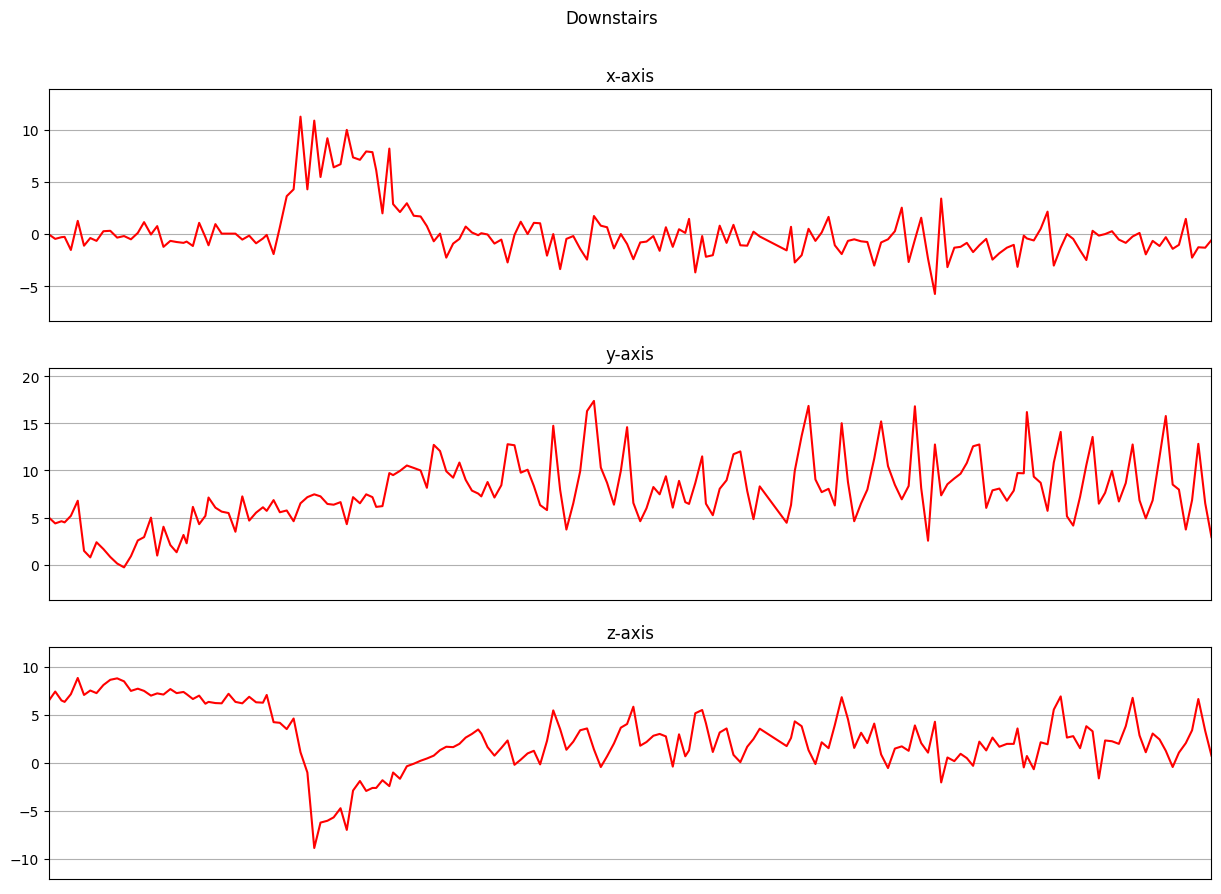

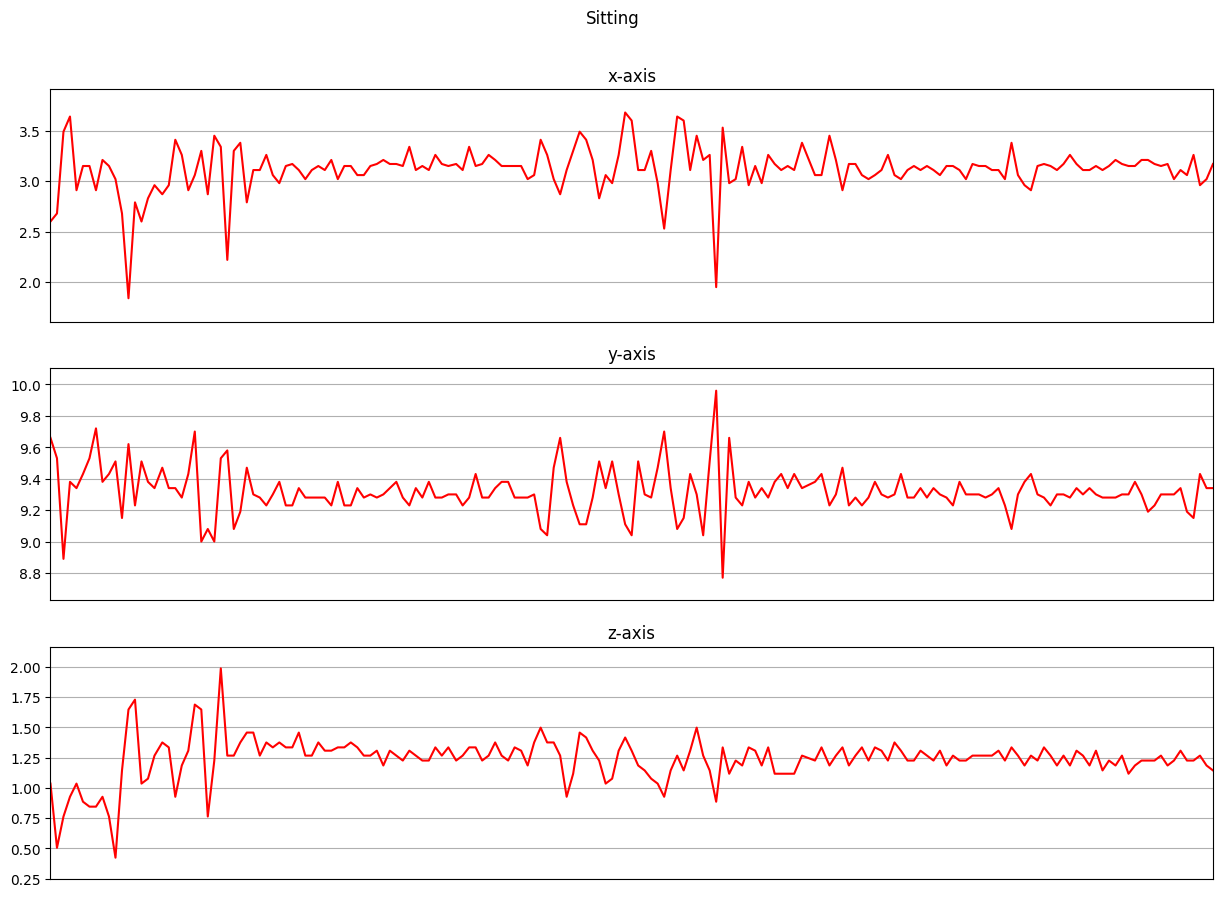

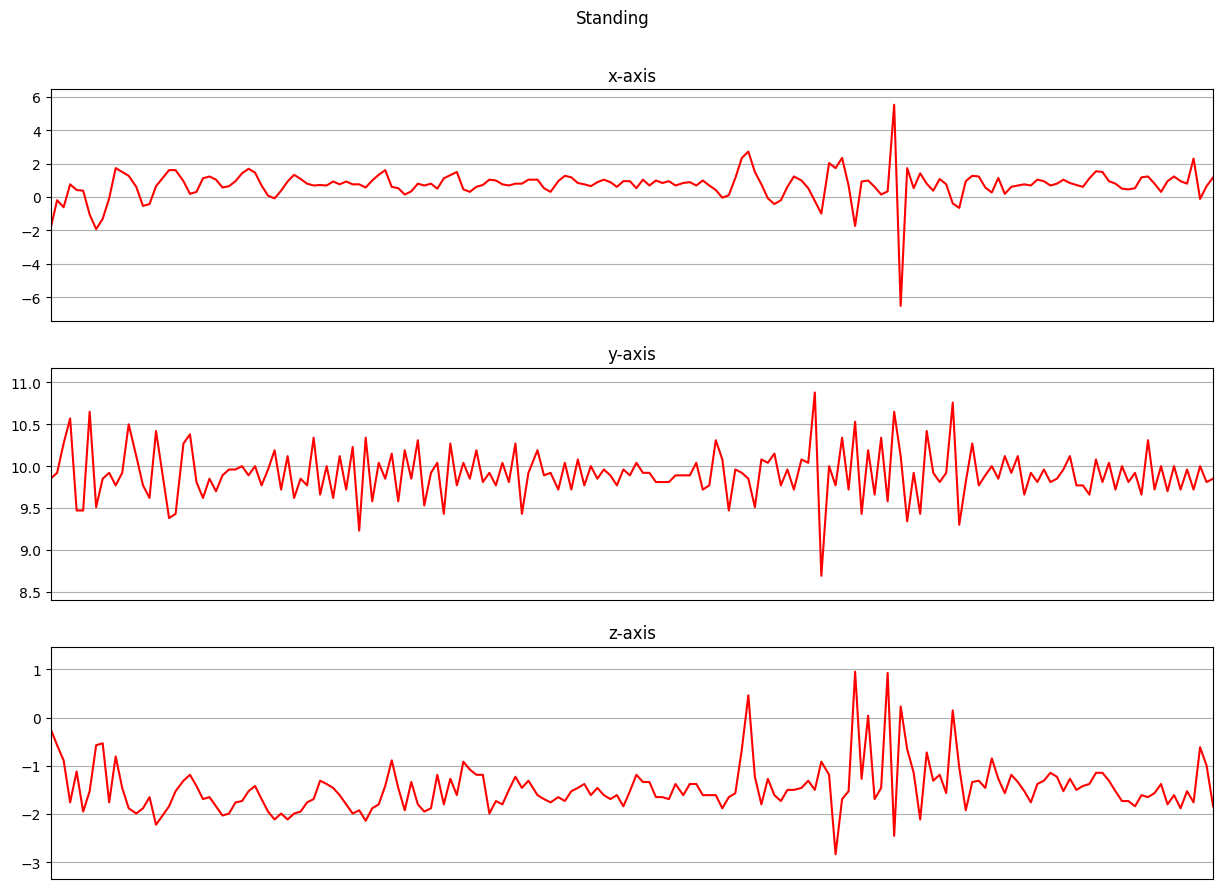

In [4]:
def axis_plot(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
for activity in df['activity'].unique():
    limit = df[df['activity'] == activity][:180]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15, 10))
    axis_plot(ax0, limit['timestamp'], limit['X'], 'x-axis')
    axis_plot(ax1, limit['timestamp'], limit['Y'], 'y-axis')
    axis_plot(ax2, limit['timestamp'], limit['Z'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [5]:
label_encode = LabelEncoder()
df['activityEncode'] = label_encode.fit_transform(df['activity'].values.ravel())
df

,user-id,activity,timestamp,X,Y,Z,activityEncode
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,2
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,2
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,2
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,2


In [6]:
interpolation_fn = interp1d(df['activityEncode'] ,df['Z'], kind='linear')
null_list = df[df['Z'].isnull()].index.tolist()
for i in null_list:
    y = df['activityEncode'][i]
    value = interpolation_fn(y)
    df['Z']=df['Z'].fillna(value)
    print(value)

# Data Split

In [7]:
## train split users between 1 and 27, test split users between 28 and 33
df_test = df[df['user-id'] > 27]
df_train = df[df['user-id'] <= 27]

# Normalization

In [8]:
df_train['X'] = (df_train['X']-df_train['X'].min())/(df_train['X'].max()-df_train['X'].min())
df_train['Y'] = (df_train['Y']-df_train['Y'].min())/(df_train['Y'].max()-df_train['Y'].min())
df_train['Z'] = (df_train['Z']-df_train['Z'].min())/(df_train['Z'].max()-df_train['Z'].min())
df_train

,user-id,activity,timestamp,X,Y,Z,activityEncode
8489,17,Walking,57869902574000,0.510163,0.741908,0.488932,5
8490,17,Walking,57870012316000,0.495703,0.751526,0.487895,5
8491,17,Walking,57870122301000,0.489850,0.742938,0.484785,5
8492,17,Walking,57870222246000,0.499490,0.748778,0.489623,5
8493,17,Walking,57870332292000,0.499490,0.750496,0.486858,5
...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,0.723205,0.454981,0.545293,2
1098200,19,Sitting,131623371431000,0.724216,0.457755,0.546308,2
1098201,19,Sitting,131623411592000,0.725228,0.459773,0.545293,2
1098202,19,Sitting,131623491487000,0.723205,0.457755,0.546308,2


# Segmentation

Reshaping of dataframe is needed for it to be fed into our model. For this, we will create a function called segments that will take in the dataframe, the label names, and the length of each record which is set to 80 steps. This function will also perform separation of features (X-acceleration, Y-acceleration, Z-acceleration) and labels in x_train and y_train respectively.

In [9]:
def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['X'].values[i:i+time_steps]
        ys = df['Y'].values[i:i+time_steps]
        zs = df['Z'].values[i:i+time_steps]
        
        label = mode(df[label_name][i:i+time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)
    
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)
    
    return reshaped_segments, labels

TIME_PERIOD = 80
STEP_DISTANCE = 40
LABEL = 'activityEncode'
X_train, y_train = segments(df_train, TIME_PERIOD, STEP_DISTANCE, LABEL)
X_test, y_test = segments(df_test, TIME_PERIOD, STEP_DISTANCE, LABEL)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((20334, 80, 3), (7118, 80, 3), (20334,), (7118,))

In [11]:
## Input and Output Dimensions
time_period, sensors = X_train.shape[1], X_train.shape[2]
num_classes = label_encode.classes_.size
print(list(label_encode.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [12]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

In [13]:
y_train_hot = to_categorical(y_train, num_classes)
print("y_train shape: ", y_train_hot.shape)

y_test_hot = to_categorical(y_test, num_classes)
print("y_test shape: ", y_test_hot.shape)

y_train shape:  (20334, 6)
y_test shape:  (7118, 6)


In [14]:
y_test_hot.shape

(7118, 6)

In [15]:
# Produce variables for CNN input/output shape
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_hot.shape[1]
print(n_timesteps, n_features, n_outputs)

80 3 6


# LSTM Model

In [35]:
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    return 0.001 * 0.9 ** epoch

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model = Sequential()
model.add(LSTM(units=128, input_shape=[n_timesteps, n_features], activation='tanh', recurrent_dropout=0.2))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.5))
model.add(Dense(units = 256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dense(n_outputs, activation = "softmax"))

In [36]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               67584     
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 6)                

In [37]:
validation_split = 0.1
history = model.fit(X_train, y_train_hot, batch_size= 192, epochs=10, verbose=True,  validation_split=validation_split)

Epoch 1/10
96/96 [==============================] - 40s 398ms/step - loss: 1.3943 - accuracy: 0.4960 - val_loss: 1.5088 - val_accuracy: 0.3525
Epoch 2/10
96/96 [==============================] - 75s 785ms/step - loss: 1.0630 - accuracy: 0.6278 - val_loss: 1.5497 - val_accuracy: 0.3525
Epoch 3/10
96/96 [==============================] - 32s 331ms/step - loss: 0.9224 - accuracy: 0.6807 - val_loss: 1.8808 - val_accuracy: 0.3525
Epoch 4/10
96/96 [==============================] - 39s 410ms/step - loss: 0.7518 - accuracy: 0.7335 - val_loss: 1.4142 - val_accuracy: 0.5251
Epoch 5/10
96/96 [==============================] - 41s 426ms/step - loss: 0.6791 - accuracy: 0.7544 - val_loss: 1.4453 - val_accuracy: 0.4223
Epoch 6/10
96/96 [==============================] - 45s 469ms/step - loss: 0.6457 - accuracy: 0.7669 - val_loss: 2.9570 - val_accuracy: 0.3741
Epoch 7/10
96/96 [==============================] - 43s 446ms/step - loss: 0.6244 - accuracy: 0.7717 - val_loss: 1.1073 - val_accuracy: 0.5969

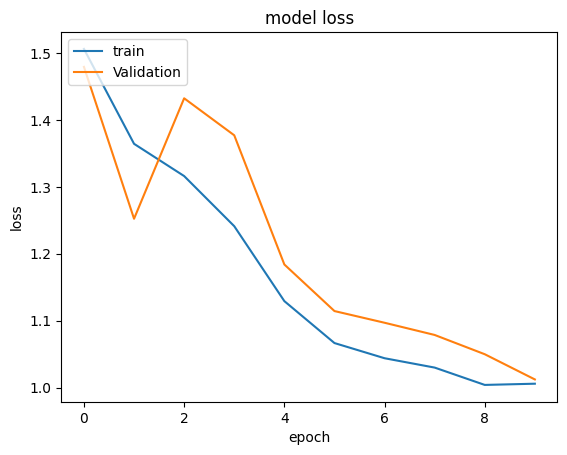

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

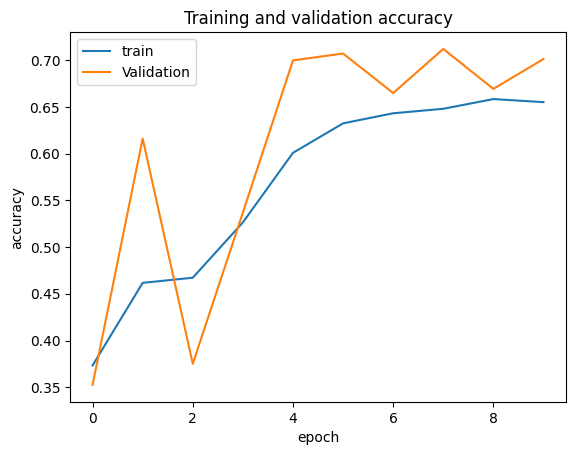

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [29]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

223/223 [==============================] - 3s 11ms/step
[[   0  697   26    0    0    0]
 [   0 1775  214    0    0    0]
 [   0   61  392    0    0    0]
 [   0  231  172    0    0    0]
 [   0  751   48    0    0    0]
 [   0 2479  272    0    0    0]]
0.3044394492835066
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       723
           1       0.30      0.89      0.44      1989
           2       0.35      0.87      0.50       453
           3       0.00      0.00      0.00       403
           4       0.00      0.00      0.00       799
           5       0.00      0.00      0.00      2751

    accuracy                           0.30      7118
   macro avg       0.11      0.29      0.16      7118
weighted avg       0.10      0.30      0.16      7118



<AxesSubplot:>

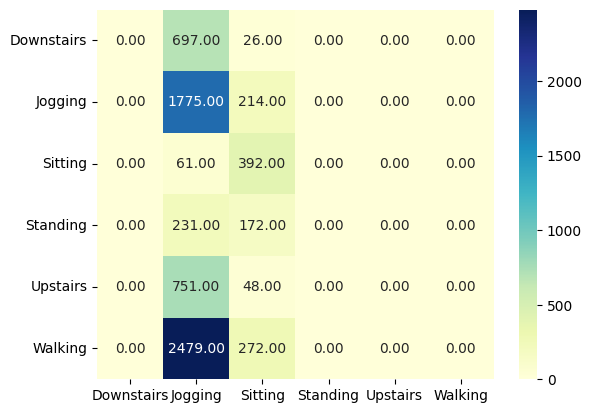

In [38]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import seaborn as sns

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test2 = np.argmax(y_test_hot, axis=-1)

LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
cm=confusion_matrix(y_test2,y_pred)

print(cm)
print(accuracy_score(y_test2,y_pred))
print(classification_report(y_test2,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')